In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from utils.utils import convert_action

website to find .csv:

In [2]:
df = pd.read_csv('./data/IBM_val.csv')
# df['Date'] = pd.to_datetime(df.Date, format="%d/%m/%Y")
# df = df.sort_values('Date')
# df.to_csv('./data/AAPL.csv')
df[['Date','Open','High','Low','Close','Volume']].head()

,Date,Open,High,Low,Close,Volume
0,2011-12-30,186.330002,186.479996,183.850006,183.880005,3530900
1,2012-01-03,186.729996,188.710007,186.000000,186.300003,5646000
2,2012-01-04,185.570007,186.330002,184.940002,185.539993,4346700
3,2012-01-05,184.809998,185.029999,183.100006,184.660004,4463100
4,2012-01-06,184.389999,184.479996,182.309998,182.539993,4897100


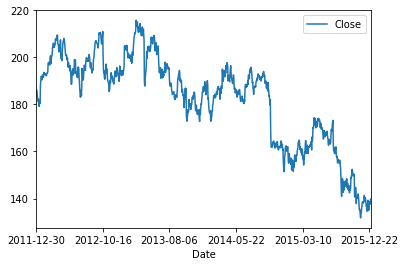

In [3]:
df.plot(x="Date", y="Close")

In [4]:
df.head()

,Unnamed: 0,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,3018,2011-12-30,186.330002,186.479996,183.850006,183.880005,138.116348,3530900
1,1,3019,2012-01-03,186.729996,188.710007,186.000000,186.300003,139.934006,5646000
2,2,3020,2012-01-04,185.570007,186.330002,184.940002,185.539993,139.363144,4346700
3,3,3021,2012-01-05,184.809998,185.029999,183.100006,184.660004,138.702209,4463100
4,4,3022,2012-01-06,184.389999,184.479996,182.309998,182.539993,137.109772,4897100


## Let the DQN trade

In [5]:
from networks.DQN import MyModel
from env.StockTradingEnv import StockTradingEnv
import tensorflow as tf

from tensorflow.keras.models import load_model

### Parameters of the DQN model (taken from main_with_dqn)

In [6]:
env = StockTradingEnv(df)

num_actions = 2
hidden_units = [64,128,256,256,128,64]
input_shape = env.observation_space.sample().shape
in_log = True ### for the environment to use logs and no divisions by max value

path_weights_a = "save_models/DQN_best" # last number is number of episodes trained
path_weights_b = "save_models/DQN_400"
path_weights_c = "save_models/DQN_1000"

### Build the Agent

In [7]:
class TradingAgent():
    """A class to simplify the trading decisions"""
    def __init__(self, model, path_weights, name):
        self.model = model
        self.model.load_weights(path_weights)
        self.name = name # name of the agent
    
    def get_action(self, state): #meant for only a single state for input
        prediction = self.model.predict(state)
        return np.argmax(prediction[0])

In [8]:
trade_model_a = MyModel(input_shape, hidden_units, num_actions)
trade_model_b = MyModel(input_shape, hidden_units, num_actions)
trade_model_c = MyModel(input_shape, hidden_units, num_actions)

# trade_model.load_weights(path_weights)
Agent_a = TradingAgent(trade_model_a, path_weights_a, "agent_a")
Agent_b = TradingAgent(trade_model_b, path_weights_b, "agent_b")
Agent_c = TradingAgent(trade_model_c, path_weights_c, "agent_c")

agents = [Agent_a]

### Run over the data frame

In [9]:
df_results = pd.DataFrame(columns=['Date','Index', 'agent_a', 'agent_b', 'agent_c'], index=df.index)
df_results['Date'] = df['Date']

with open("./data/actions.txt", "rb") as fp:   # Unpickling
    actions = pickle.load(fp)

# Compute the Index value
for i in range(len(df.loc[:, 'Open'].values) - 6):
    df_results.loc[i+5, "Index"] = df.loc[i+5, "Close"] * env.initial_account_balance / df.loc[5, "Close"] # i + 5 because of the format of the data
    
# Compute the Agents' net_worth
for Agent in agents:
    env = StockTradingEnv(df)
    input_shape = env.observation_space.sample().shape
    observation = env.reset_to_day_one().reshape(1,input_shape[0],input_shape[1]).astype('float32') # necessary to reshape each observation
    
    for i in range(len(df.loc[:, 'Open'].values) - 6):
        action = Agent.get_action(observation.reshape(1,input_shape[0],input_shape[1]).astype('float32'))
                    
        action = convert_action(action, binary_action=True)
        observation, reward, done, _ = env.step(action)

        df_results.loc[i+5, Agent.name] = env.net_worth

        print("\r {}, day {} out of {}".format(Agent.name, i, len(df.loc[:, 'Open'].values) - 7), end = "")
    print("")
    
    print("last net_worth: {}".format(env.net_worth))
    
    env.close()

 agent_a, day 999 out of 999
last net_worth: 9931.31131150229


### Visualize the results

#### On training set

#### On validation set

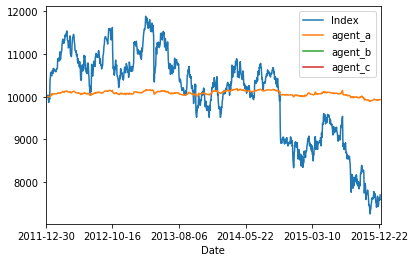

In [10]:
fig = df_results.plot(x="Date", y=["Index", "agent_a", "agent_b", "agent_c"]).get_figure()
fig.savefig("imgs/DQN_mlp.png")